# 사용한 라이브러리

In [1]:
import random
import numpy as np
from collections import deque
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform
import tensorflow as tf
import matplotlib.pyplot as plt

# NN

In [2]:
class NN(tf.keras.Model):
    def __init__(self, action_size):
        super(NN, self).__init__()
        self.fc1 = Dense(24, activation = 'relu')
        self.fc2 = Dense(24, activation = 'relu')
        self.fc_out = Dense(action_size, kernel_initializer = RandomUniform(-1e-3, 1e-3))

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q

# DQN

In [1]:
class DQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.001
        self.batch_size = 64
        self.train_start = 1000

        self.memory = deque(maxlen = 2000)

        self.model = NN(self.action_size)
        self.target_model = NN(self.action_size)
        self.optimizer = Adam(learning_rate = self.learning_rate)

        self.update_target_model()

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q = self.model(state) # 리스트 형태로 반환됨
            return np.argmax(q[0])

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        mini_batch = random.sample(self.memory, self.batch_size)
        states = np.array([sample[0][0] for sample in mini_batch])
        actions = np.array([sample[1] for sample in mini_batch])
        rewards = np.array([sample[2] for sample in mini_batch])
        next_states = np.array([sample[3][0] for sample in mini_batch])
        dones = np.array([sample[4] for sample in mini_batch])

        model_params = self.model.trainable_variables
            
        with tf.GradientTape() as tape:
            predicts = self.model(states)
            one_hot_action = tf.one_hot(actions , self.action_size)
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)
        
            target_predicts = self.target_model(next_states)
            target_predicts = tf.stop_gradient(target_predicts)
        
            max_q = np.amax(target_predicts, axis=-1)
            targets = rewards + (1-dones) * self.discount_factor * max_q
            loss = tf.reduce_mean(tf.square(targets - predicts))
        
        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))

# parameter 정의

In [4]:
state_size = 1
action_size = 3
index = 0 # GRU
agent = DQN(state_size, action_size)

scores, episodes = [], []
score_avg = 0

EPISODES = 20000

# GRU 모델의 출력 데이터 및 실제 데이터 불러오기

In [5]:
# GRU 모델에서 window_size = 1인 경우, 단기적인 예측 결과
gru_output_1 = np.load('window_size/gru_outputs_1.npy')
# 데이터 크기 확인
gru_output_1.shape

(1, 7814)

In [6]:
# GRU 모델에서 window_size = 10인 경우, 중단기적인 예측 결과
gru_output_10 = np.load('window_size/gru_outputs_10.npy')
# 데이터 크기 확인
gru_output_10.shape

(1, 7813)

In [7]:
# GRU 모델에서 window_size = 100인 경우, 중단기적인 예측 결과
gru_output_100 = np.load('window_size/gru_outputs_100.npy')
# 데이터 크기 확인
gru_output_100.shape

(1, 7804)

In [8]:
# 실제 데이터 값
real = np.load('window_size/targets.npy')
# 데이터 크기 확인
real.shape

(1, 7814)

# 데이터 수 맞추기

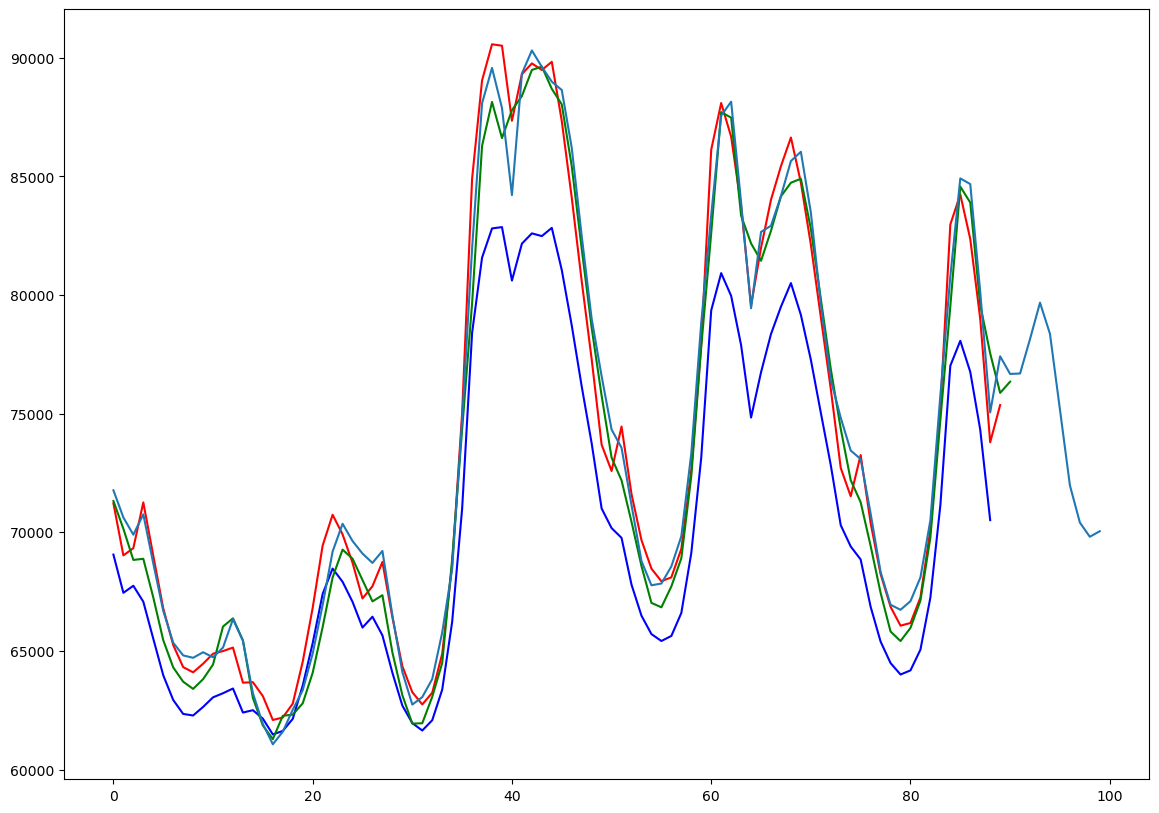

In [9]:
plt.figure(figsize = (14, 10))
plt.plot(real[0][10:100], color = "r")
plt.plot(gru_output_1[0][11:100], color = "b")
plt.plot(gru_output_10[0][9:100], color = "g")
plt.plot(gru_output_100[0][0:100])
plt.show()

In [10]:
new_real = real[0][10:7813]
new_gru_output_1 = gru_output_1[0][11:7814]
new_gru_output_10 = gru_output_10[0][9:7812]
new_gru_output_100 = gru_output_100[0][0:7803]

In [11]:
print(new_real.shape)
print(new_gru_output_1.shape)
print(new_gru_output_10.shape)
print(new_gru_output_100.shape)

(7803,)
(7803,)
(7803,)
(7803,)


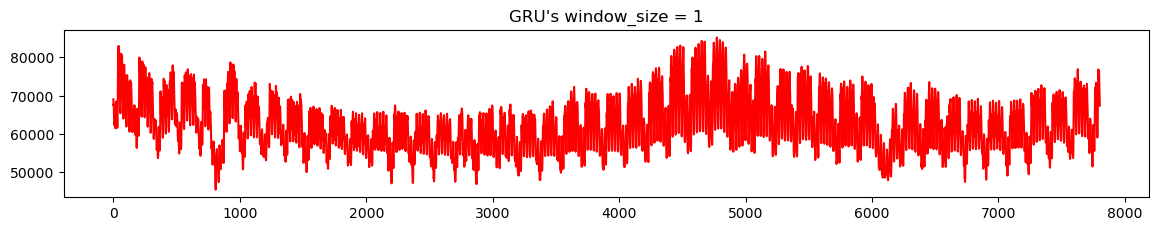

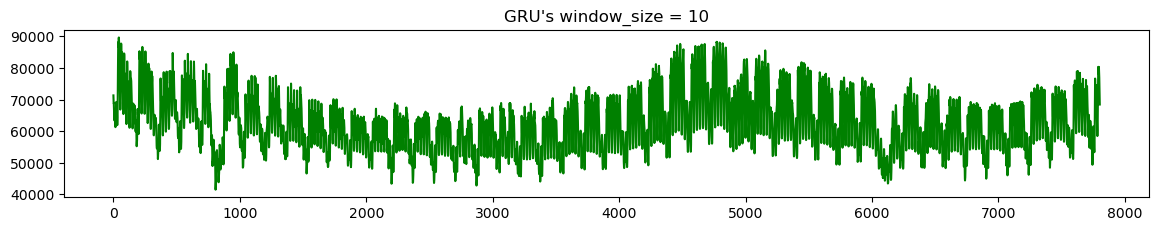

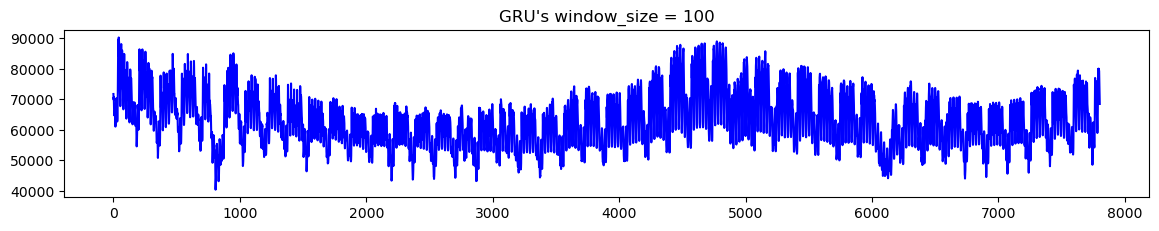

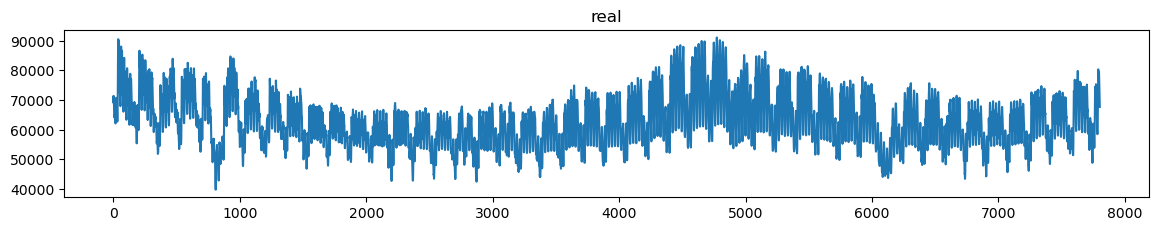

In [12]:
plt.figure(figsize = (14, 10))
plt.subplot(4, 1, 1)
plt.plot(new_gru_output_1[:], color = "r")
plt.title("GRU's window_size = 1")
plt.show()

plt.figure(figsize = (14, 10))
plt.subplot(4, 1, 2)
plt.plot(new_gru_output_10[:], color = "g")
plt.title("GRU's window_size = 10")
plt.show()

plt.figure(figsize = (14, 10))
plt.subplot(4, 1, 3)
plt.plot(new_gru_output_100[:], color = "b")
plt.title("GRU's window_size = 100")
plt.show()

plt.figure(figsize = (14, 10))
plt.subplot(4, 1, 3)
plt.plot(new_real[:])
plt.title("real")
plt.show()

# EPISODES

In [2]:
for e in range(EPISODES):
    done = False
    score = 0
    
    state = new_real[0] # 전력 수요량 데이터 한 점
    state = np.reshape(state, [1, state_size])
    
    # data_length = new_gru_output_1.shape
    count = 0
    index = 1
    shot = 0
    long =0
    while not done:
        action = agent.get_action(state) # 내가 행동을 결정하는 방법
        
        if action == 0:
            next_state = new_gru_output_1[index + 1]
            shot = next_state
        elif action == 1:
            next_state = new_gru_output_100[index + 1]
            long = next_state
            
        next_state = np.reshape(next_state, [1, state_size]) # next_state를 [1, state_size]의 배열로 재배열 
        # print("___________________________________")
        # print(f"GRU의 출력 데이터 : {state}")
            
        # reward 계산 > 이 부분은 후에 구체적으로 변경 다시 해야 함
        if next_state == shot:
            if abs(new_real[index + 1] - shot) < abs(new_real[index + 1] - long) : # (ra - 모델이 선택한 값) < (실제 값 - 선택 안된 값)
                reward = 1
            else:
                reward = -1
        elif next_state == long:
            if abs(new_real[index + 1] - long) < abs(new_real[index + 1] - shot) : # (ra - 모델이 선택한 값) < (실제 값 - 선택 안된 값)
                reward = 1
            else:
                reward = -1
        
        if count == '내가 예측할 데이터 수':
            done = True
            
        if reward < 0: # 막 정한 수
            done = True  
        #print('보상 : ', reward)
        index = index + 1
        score += reward
        agent.append_sample(state, action, reward, next_state, done)

        if len(agent.memory) >= agent.train_start:
            agent.train_model()

        
        # 다음 state 인덱스로 이동
        if index == 7803 - 1:
            done = True  # 데이터의 끝에 도달
        
        state = new_real[index]
        state = np.reshape(state, [1, state_size])
        
        if done:
            agent.update_target_model()
            count = count + 1
            print(f"episode : {e} | score : {score}")
            print("___________________________________")
            scores.append(score_avg)
            episodes.append(e)


NameError: name 'EPISODES' is not defined

In [ ]:
import matplotlib.pyplot as plt
plt.plot(episodes, scores)